In [4]:
fluido = 'g' #g, glicerolo; s, sapone

In [5]:
import importlib
import funzioni as f
importlib.reload(f)

import math

import matplotlib.pyplot as plt
import numpy as np
import itertools

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

%config InlineBackend.figure_format = 'svg'

plt.style.use("grafici.mplstyle")

In [6]:
if fluido == 'g':
    input_file = "glicerolo.txt"
    rho_0 = 1260
    srho_0 = 10
    nome = "gli"
    
if fluido == 's':
    input_file = "sapone.txt"
    rho_0 = 1032
    srho_0 = 1
    nome = "sap"

sx = (0.5e-3) / math.sqrt(24) #errore distribuzione triangolare con risoluzione 5mm
st = (0.001) / math.sqrt(12) #errore distribuzione uniforme con risoluzione 0.001s

sd = 1e-5
g = 9.8065855
sg = 0.001
rho = 7870
srho = 1
srho_TOT = math.sqrt( srho**2 + srho_0**2)

R = 0.045
sR = 0.0001
h = 0.7
sh = 0.001

def correzione(d):
    if (fluido == 'g'):
        r = d/2
        return (1+2.33*(r/R))*(1+3.3*(r/h))
        #return 1
    if (fluido == 's'):
        return 1

def scorrezione(d):
    r = d/2
    sr = sd/2
    termine1 = 1+2.33*(r/R)
    stermine1 = math.sqrt(((2.33 / R) * sr)**2 + ((2.33 * r / (R**2)) * sR)**2)
    termine2 = 1+3.3*(r/h)
    stermine2 = math.sqrt(((3.3 / h) * sr)**2 + ((3.3 * r / (h**2)) * sh)**2)
    if (fluido == 'g'):
        return (stermine1 / termine1)**2 + (stermine2 / termine2)**2
        #return 0
    if (fluido == 's'):
        return 0

# 1. Migliori Stime

### 1.1 Raccolta Dati

Sono state calcolati i valori medi delle quattro misure ripetute dei tempi, usando come incertezza la deviazione standard campionaria. I campioni dei tempi (quattro misure ripetute) non sonon gaussiani il chè vuol dire che fare una media con deviazione standard della media non è molto sensato: si può comunque definire una media(?) ma meglio definire una deviazione standard campionaria.

In [7]:
x_serie = []
t_serie = []
st_serie = []
d_serie = [0.00150,0.00200,0.00318,0.00476,0.00635] #diametri in metri

with open (input_file, "r") as input:

    x = []
    t = []
    st = []

    for riga in input:

        if riga.isspace():
            x_serie.append(x.copy())
            t_serie.append(t.copy())
            st_serie.append(st.copy())
            x.clear()
            t.clear()
            st.clear()
            continue

        x0, t1, t2, t3, t4 = map(float, riga.split())
        t0 = [t1, t2, t3, t4]

        t_medio = f.media(t0)
        #st_medio = f.dev(t0) / math.sqrt(len(t0))
        st_medio = f.dev(t0)

        x.append(x0)
        t.append(t_medio)
        st.append(st_medio)
    
    if x:
        x_serie.append(x.copy())
        t_serie.append(t.copy())
        st_serie.append(st.copy())
        x.clear()
        t.clear()
        st.clear()
del x0, t1, t2, t3, t4, t0, t_medio, st_medio, x, t, st

print(x_serie)
print(t_serie)
print(st_serie)

[[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], [0.05, 0.15, 0.25, 0.35, 0.45], [0.05, 0.15, 0.25, 0.35, 0.45]]
[[8.69275, 17.551000000000002, 26.40375, 35.345, 44.181250000000006, 53.1365, 62.069, 71.10125, 80.18924999999999, 89.251], [4.7775, 9.71475, 14.641, 19.68175, 24.655749999999998, 29.64, 34.0405, 40.11025, 45.176500000000004, 50.1665], [1.9, 3.884, 5.83675, 7.855499999999999, 9.79225, 11.791249999999998, 13.9465, 15.993749999999999, 18.037750000000003, 20.085749999999997], [0.8634999999999999, 2.6477500000000003, 4.460000000000001, 6.18075, 7.986500000000001], [0.59825, 1.58625, 2.65375, 3.67475, 4.6935]]
[[0.07285773809280685, 0.15401082213056724, 0.21347814095749063, 0.15219943057274024, 0.23663808512860732, 0.295434707958741, 0.2682473982477105, 0.33756814126928236, 0.3484569557348524, 0.4942745525852341], [0.03529400326778872, 0.08897331060492214, 0.

### 1.2 Grafico Confronto Andamenti Tempi Caduta

Nome output "nome_confronto_tempi.pdf".

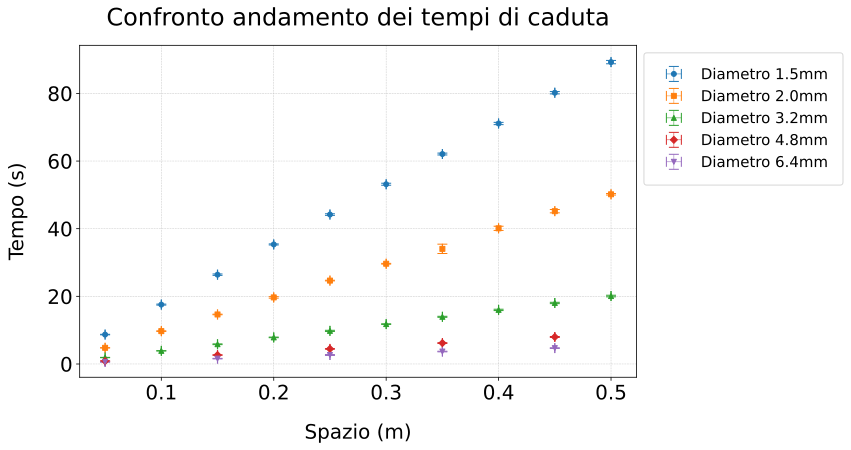

In [8]:
#colors = ['blue', 'orange', 'pink', 'violet', 'purple', 'brown']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
color_cycle = itertools.cycle(colors)
diameter = ['1.5','2.0','3.2','4.8','6.4']
diameter_cycle = itertools.cycle(diameter)
markers = ['o','s','^','D','v']
marker_cycle = itertools.cycle(markers)

plt.figure(dpi=1000,figsize=(10, 6))

for i in range(len(x_serie)):
    color = next(color_cycle)
    diameter = next(diameter_cycle)
    marker = next(marker_cycle)
    label = f"Diametro {diameter}mm"
    plt.errorbar(x_serie[i], t_serie[i], xerr=sx, yerr=st_serie[i], fmt=marker, elinewidth=0.5, capsize=5, capthick=1, markersize=5, label=label, color=color)

plt.xlabel("Spazio (m)")
plt.ylabel("Tempo (s)")
plt.title("Confronto andamento dei tempi di caduta")
plt.legend(bbox_to_anchor = (1,1))
plt.grid()
plt.savefig(f"{nome}2.pdf", format="pdf", bbox_inches='tight')
plt.show()

### 1.3 Interpolazione

Nome output "nome_elaborato_migliori_stime.txt". Da verificare la compatibilità dell'intercetta ("a") con l'origine con un test di Student. Minimi quadrati II con incertezze sui tempi (ordinate) date dalla deviazione standard campionaria, e quindi variabili.

In [9]:
output_name = f"{nome}_elaborato_migliori_stime.txt"
with open (output_name, 'w') as file:
    file.write('\n')
for i in range (len(x_serie)):
    f.elaborato2(x_serie[i], t_serie[i], st_serie[i], output_name, i)

del output_name

### 1.4 Calcolo Viscosità

Le liste _falsi contengono le velocità non corrette, che verranno usate solo per generare i grafici e non nel resto del codice.

In [10]:
vv =[]
vsv = []
veta = []
vseta = []

vv_falsi = []
vsv_falsi = []
veta_falsi = []
vseta_falsi = []

for i in range (len(d_serie)):
    delta = f.delta2(x_serie[i], st_serie[i])
    b = f.b2(x_serie[i], t_serie[i], st_serie[i], delta)
    sb = f.sb2(x_serie[i], st_serie[i], delta)
    v = (1/b)*correzione(d_serie[i])
    sv = v * math.sqrt((sb / b )**2 + scorrezione(d_serie[i]))
    eta = (d_serie[i]**2) * (rho - rho_0)/(18 * v) * g
    seta = eta*math.sqrt( (2*(sd/d_serie[i]))**2 + (srho_TOT/(rho-rho_0))**2 + (sv/v)**2 + (sg/g)**2 )

    vv.append(v)
    vsv.append(sv)
    veta.append(eta)
    vseta.append(seta)

    v_falso = 1/b
    sv_falso = v_falso * math.sqrt((sb / b )**2)
    eta_falso = (d_serie[i]**2) * (rho - rho_0)/(18 * v_falso) * g
    seta_falso = eta_falso*math.sqrt( (2*(sd/d_serie[i]))**2 + (srho_TOT/(rho-rho_0))**2 + (sv_falso/v_falso)**2 + (sg/g)**2 )

    vv_falsi.append(v_falso)
    vsv_falsi.append(sv_falso)
    veta_falsi.append(eta_falso)
    vseta_falsi.append(seta_falso)

del v, sv, eta, seta

print(vv)
print(vsv)
print(veta)
print(vseta)

[0.005848584630897728, 0.010575679262215221, 0.027260964308315698, 0.06382788558202258, 0.11512694303169776]
[1.5107723646593004e-05, 3.106982273421193e-05, 0.0001543042201740087, 0.0012116548845597988, 0.002848823025224685]
[1.3854106216688666, 1.3620670712239062, 1.3358564733519138, 1.2783513108446085, 1.261296675770493]
[0.018933674032854793, 0.014347230349116273, 0.011484947896080115, 0.024930684589884042, 0.03152131567049107]


### 1.5 Grafico Verifica Legge Stokes

Grafici andamenti viscosità-diametro quadro e velocità-diametro quadro. Nome output "nome_eta.pdf" 

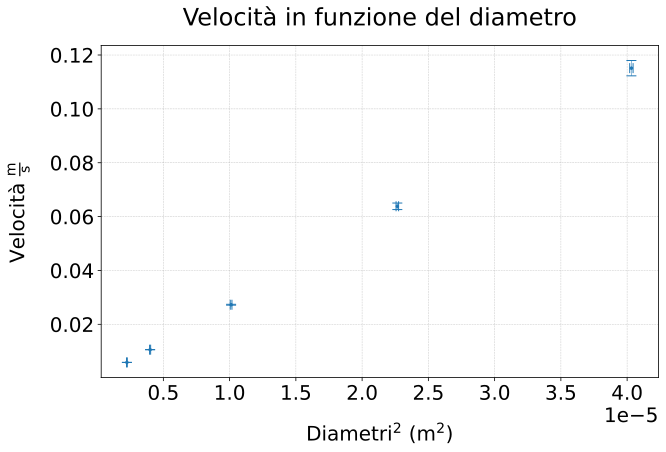

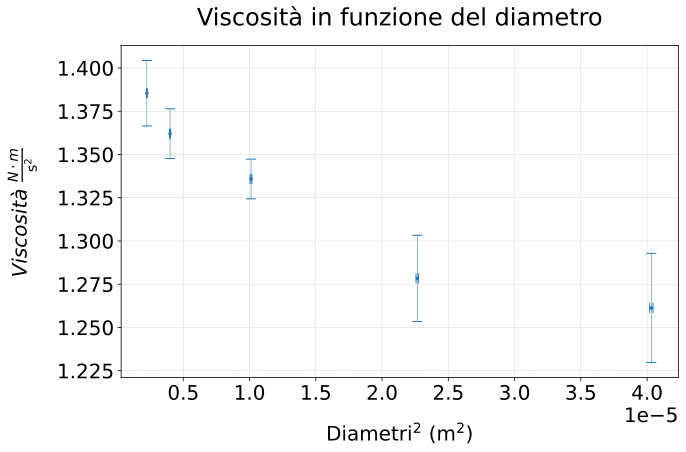

In [11]:
d = np.array(d_serie)
vv = np.array(vv)
vsv = np.array(vsv)
veta = np.array(veta)
vseta = np.array(vseta)

min_d = min(d_serie)
max_d = max(d_serie)
D = np.linspace(min_d, max_d, 50)
min_vv = min(vv)
max_vv = max(vv)
VV = np.linspace(min_vv, max_vv, 50)
min_veta = min(veta)
max_veta = max(veta)
VETA = np.linspace(min_veta, max_veta, 50)

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6), dpi=1000)

ax1.errorbar(d**2, vv, xerr=2*d*sd, yerr=vsv, fmt='.', elinewidth=0.5, capsize=5, capthick=1, markersize=5)

ax1.set_xlabel(r"$\mathrm{Diametri^2\ (m^2)}$")
ax1.set_ylabel(r"$\mathrm{Velocità\ \frac{m}{s}}$")
ax1.set_title("Velocità in funzione del diametro")

plt.grid()
plt.savefig(f"{nome}1.1.pdf", format="pdf", bbox_inches='tight')
plt.show()

fig, (ax2) = plt.subplots(1, 1, figsize=(10, 6), dpi=1000)

ax2.errorbar(d**2, veta, xerr=2*d*sd, yerr=vseta, fmt='.', elinewidth=0.5, capsize=5, capthick=1, markersize=5)

ax2.set_xlabel(r"$\mathrm{Diametri^2\ (m^2)}$")
ax2.set_ylabel(r"${Viscosità \ \frac{N \cdot m}{\mathrm{s^2}}}$")
ax2.set_title("Viscosità in funzione del diametro")

plt.grid()
plt.savefig(f"{nome}1.2.pdf", format="pdf", bbox_inches='tight')
plt.show()

### 1.6 Valutazione Verifica Legge Stokes

Nome output "nome_elaborato_stokes.txt": 1 = "diametri-velocità", 2 = "diametri-viscosità".

In [12]:
d_serie = np.array(d_serie)
vv = np.array(vv)
vsv = np.array(vsv)
veta = np.array(veta)
vseta = np.array(vseta)

output_name = f"{nome}_elaborato_stokes.txt"
with open (output_name, 'w') as file:
    file.write('\n')
    f.elaborato2(d_serie**2, vv, vsv, output_name, 0)
    f.elaborato2(d_serie**2, veta, vseta, output_name, 1)

del output_name

### 1.7 Grafici Senza Correzione Velocità

Grafici andamenti viscosità-diametro quadro e velocità-diametro quadro. Nome output "nome_eta_nocorrezione.pdf" 

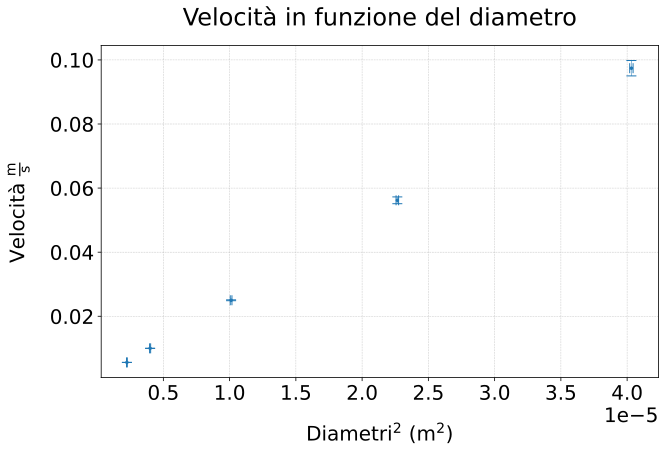

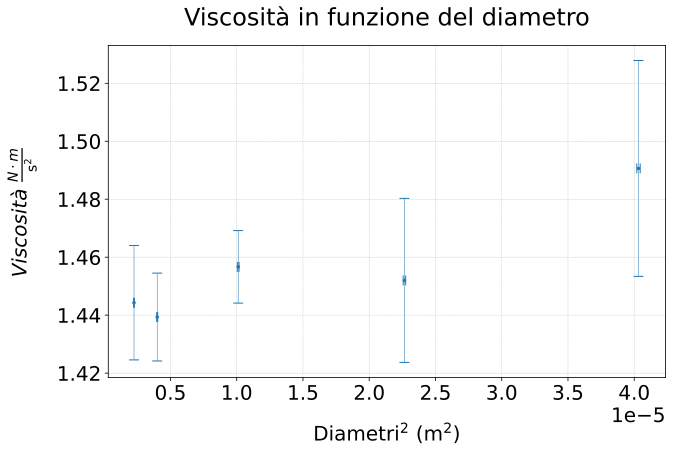

In [13]:
d = np.array(d_serie)
vv = np.array(vv)
vsv = np.array(vsv)

fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6), dpi=1000)

ax1.errorbar(d**2, vv_falsi, xerr=2*d*sd, yerr=vsv_falsi, fmt='.', elinewidth=0.5, capsize=5, capthick=1, markersize=5)

ax1.set_xlabel(r"$\mathrm{Diametri^2\ (m^2)}$")
ax1.set_ylabel(r"$\mathrm{Velocità\ \frac{m}{s}}$")
ax1.set_title("Velocità in funzione del diametro")

plt.grid()
plt.savefig(f"{nome}1.1_nocorrezione.pdf", format="pdf")
plt.show()

fig, (ax2) = plt.subplots(1, 1, figsize=(10, 6), dpi=1000)

ax2.errorbar(d**2, veta_falsi, xerr=2*d*sd, yerr=vseta_falsi, fmt='.', elinewidth=0.5, capsize=5, capthick=1, markersize=5)

ax2.set_xlabel(r"$\mathrm{Diametri^2\ (m^2)}$")
ax2.set_ylabel(r"${Viscosità \ \frac{N \cdot m}{\mathrm{s^2}}}$")
ax2.set_title("Viscosità in funzione del diametro")

plt.grid()
plt.savefig(f"{nome}1.2_nocorrezione.pdf", format="pdf")
plt.show()

### 1.8 Valutazione Correzione Velocità

Nome output "nome_elaborato_nocorrezione.txt".

In [14]:
d_serie = np.array(d_serie)
vv_falsi = np.array(vv_falsi)
vsv_falsi = np.array(vsv_falsi)
veta_falsi = np.array(veta_falsi)
vseta_falsi = np.array(vseta_falsi)

output_name = f"{nome}_elaborato_nocorrezione.txt"
with open (output_name, 'w') as file:
    file.write('\n')
    f.elaborato2(d_serie**2, vv_falsi, vsv_falsi, output_name, 0)
    f.elaborato2(d_serie**2, veta_falsi, vseta_falsi, output_name, 1)

del output_name

# 2. Intervalli di Spazio

### 2.1 Calcolo Viscosità

Dopo aver calcolato i delta si calcola la velocità con la formula v = delta_x / delta_t, da cui poi si ricavano i valori delle viscosità per ogni intervallo di spazio, cioè la viscosità media per un dato diametro per lo spazio da 0.05 a 010, da 0.10 a 0.15 e così via. Le incertezze sono ricavate con delle propagazioni.

In [15]:
veta_intervalli = []
vseta_intervalli = []
for i in range (len(t_serie)):
    veta_i = []
    vseta_i = []
    for j in range (len(t_serie[i])):
        x = x_serie[i][1] - x_serie[i][0]
        sx_int = math.sqrt (2) * sx
        if j == 0:
            t = t_serie[i][j]
            st = st_serie[i][j]
        else:
            t = t_serie[i][j] - t_serie[i][j-1]
            st = math.sqrt( st_serie[i][j]**2 + st_serie[i][j-1]**2 )
        v = x/t * correzione(d_serie[i])
        sv = v * math.sqrt( (sx_int/x)**2 + (st/t)**2 + scorrezione(d_serie[i]))
        eta = d[i]**2 * (rho - rho_0) * g / (18 * v)
        seta = eta * math.sqrt( (2 * (sd/d[i]))**2 + (srho_TOT/(rho-rho_0))**2 + (sv/v)**2 + (sg/g)**2 )
        veta_i.append(eta)
        vseta_i.append(seta)
    veta_intervalli.append(veta_i.copy())
    vseta_intervalli.append(vseta_i.copy())

del x, t, st, v, sv, eta, seta, veta_i, vseta_i

print(veta_intervalli)
print(vseta_intervalli)

[[np.float64(1.351256411079465), np.float64(1.3769827849005978), np.float64(1.376127829879351), np.float64(1.3898848334030387), np.float64(1.3735629648156142), np.float64(1.3920610825480275), np.float64(1.3885246776874205), np.float64(1.4040304528454728), np.float64(1.4126965878335587), np.float64(1.4086161206867058)], [np.float64(1.3024794747364143), np.float64(1.3460317711443983), np.float64(1.3430328649754601), np.float64(1.374248751915768), np.float64(1.356050844026985), np.float64(1.3588452793207697), np.float64(1.1996987814919085), np.float64(1.6547827926282257), np.float64(1.381200761671034), np.float64(1.3604128893636216)], [np.float64(1.2690625955160806), np.float64(1.3251685207915282), np.float64(1.3042957807336986), np.float64(1.3483790077358349), np.float64(1.2936089378240891), np.float64(1.3351874360192861), np.float64(1.4395511363084397), np.float64(1.3674149466685757), np.float64(1.3652441817025651), np.float64(1.3679158924299613)], [np.float64(0.6203092342400884), np.fl

### 2.2 Grafici Confronto Viscosità Intervalli di Spazio

Grafico 2D, nome output "nome_eta_intervalli.pdf".

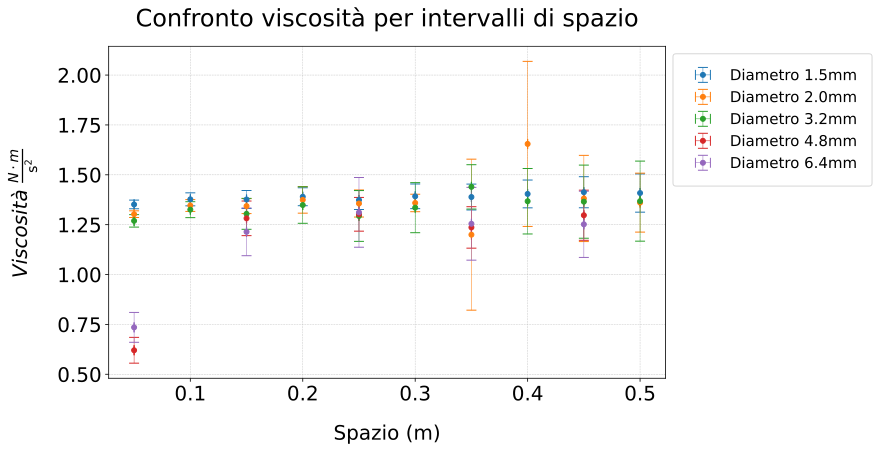

In [16]:
#colors = ['blue', 'orange', 'pink', 'violet', 'purple', 'brown']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
color_cycle = itertools.cycle(colors)
diameter = ['1.5','2.0','3.2','4.8','6.4']
diameter_cycle = itertools.cycle(diameter)

plt.figure(dpi=1000,figsize=(10, 6))
for i in range (len(veta_intervalli)):
    color = next(color_cycle)
    diameter = next(diameter_cycle)
    label = f"Diametro {diameter}mm"
    plt.errorbar(x_serie[i], veta_intervalli[i], xerr=sx, yerr=vseta_intervalli[i], fmt='o', elinewidth=0.5, capsize=5, capthick=1, markersize=5, color=color, label = label)

plt.xlabel("Spazio (m)")
plt.ylabel(r"${Viscosità \ \frac{N \cdot m}{\mathrm{s^2}}}$")
plt.title("Confronto viscosità per intervalli di spazio")
plt.savefig(f"{nome}4.1.pdf", format="pdf", bbox_inches='tight')
plt.legend(bbox_to_anchor=(1,1))
plt.grid()
plt.show()

Grafico 3D, nome output "nome_3d_eta_intervalli.pdf" e animazione "nome_3d_eta_intervalli.gif".

In [17]:
#colors = ['blue', 'orange', 'pink', 'violet', 'purple', 'brown']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
color_cycle = itertools.cycle(colors)
diameter = ['1.5','2.0','3.2','4.8','6.4']
diameter_cycle = itertools.cycle(diameter)

vy = []
vy_temporaneo = []
for i in range (len(veta_intervalli)):
    for j in range (len(veta_intervalli[i])):
        vy_temporaneo.append(i)
    vy.append(vy_temporaneo.copy())
    vy_temporaneo.clear()

fig = plt.figure(dpi=200, figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

min_x = min(x_serie[0]) - 0.1
max_x = max(x_serie[0]) + 0.1
min_z = min(min(veta_intervalli[i] for i in range (len(veta_intervalli)))) -1
max_z = max(max(veta_intervalli[i] for i in range (len(veta_intervalli)))) +5
x_plane = np.linspace(min_x, max_x, 100)
z_plane = np.linspace(min_z, max_z, 100)
X, Z = np.meshgrid(x_plane, z_plane)

for i in range (len(veta_intervalli)):
    Y = i * np.ones_like(X)
    color = next(color_cycle)
    diameter = next(diameter_cycle)
    label = f"Diametro {diameter}mm"
    ax.plot_surface(X, Y, Z, color=color, alpha=0.3)
    ax.errorbar(x_serie[i], vy[i], veta_intervalli[i], xerr=sx, zerr=vseta_intervalli[i], fmt='o', elinewidth=0.5, capsize=5, capthick=1, markersize=5, color=color, label = label)

ax.view_init(elev=15, azim=-15)
ax.set_xlabel("Spazio (m)")
ax.set_zlabel(r"${Viscosità \ \frac{N \cdot m}{\mathrm{s^2}}}$")
ax.set_title("Grafico di superficie viscosità per intervalli di spazio")
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(f"{nome}4.2.pdf", format="pdf", bbox_inches='tight')
plt.show()

"""def rotate(frame):
    ax.view_init(elev=20, azim=frame)

ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, 2), interval=10000) #2
ani.save(f"{nome}_3d_eta_intervalli.gif", writer='imagemagick', fps=15)
plt.show()"""

'def rotate(frame):\n    ax.view_init(elev=20, azim=frame)\n\nani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, 2), interval=10000) #2\nani.save(f"{nome}_3d_eta_intervalli.gif", writer=\'imagemagick\', fps=15)\nplt.show()'

### 2.3 Valutazione Effetto Profondità

Con un interpolazione (minimi quadrati II, ordinate eta) si verifica la compatibilità della pendenza con una pendenza nulla. Nome output "nome_elaborato_profondita.txt".

In [18]:
output_name = f"{nome}_elaborato_profondita.txt"
with open (output_name, 'w') as file:
    file.write('\n')
for i in range (len(x_serie)):
    f.elaborato2(x_serie[i], veta_intervalli[i],vseta_intervalli[i],output_name, i)

del output_name

# 3. Intervalli di Tempo

### 3.1 Raccolta Dati

Raccolta dati in "colonne", quindi per ogni sferetta singolarmente. La lista t_tempi è una lista di liste di liste: contiene tante liste quanti sono i diametri (cinque) le quali a loro volta contengono tante liste quante sono le misure ripetute (quattro per t_tempi). La lista x_tempi è una lista di liste e contiene tante liste quanti sono i diametri.

In [19]:
x_tempi = []
t_tempi = []

with open (input_file, 'r') as input:
    
    x_t = []
    tempi1 = []
    tempi2 = []
    tempi3 = []
    tempi4 = []

    for riga in input:

        if riga.isspace():
            x_tempi.append(x_t.copy())
            t_tempi.append([tempi1.copy(), tempi2.copy(), tempi3.copy(), tempi4.copy()])
            x_t.clear()
            tempi1.clear()
            tempi2.clear()
            tempi3.clear()
            tempi4.clear()
            continue

        x0, t1, t2, t3, t4 = map(float, riga.split())

        x_t.append(x0)
        tempi1.append(t1)
        tempi2.append(t2)
        tempi3.append(t3)
        tempi4.append(t4)
        
    x_tempi.append(x_t.copy())
    t_tempi.append([tempi1.copy(), tempi2.copy(), tempi3.copy(), tempi4.copy()])
    x_t.clear()
    tempi1.clear()
    tempi2.clear()
    tempi3.clear()
    tempi4.clear()

del x0, t1, t2, t3, t4, x_t, tempi1, tempi2, tempi3, tempi4

print (x_tempi)
print (t_tempi)

[[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5], [0.05, 0.15, 0.25, 0.35, 0.45], [0.05, 0.15, 0.25, 0.35, 0.45]]
[[[8.795, 17.759, 26.717, 35.568, 44.517, 53.555, 62.452, 71.582, 80.666, 89.946], [8.639, 17.574, 26.286, 35.299, 44.157, 53.116, 62.051, 71.085, 80.18, 89.252], [8.642, 17.454, 26.359, 35.225, 43.97, 52.997, 61.92, 70.905, 80.073, 88.965], [8.695, 17.417, 26.253, 35.288, 44.081, 52.878, 61.853, 70.833, 79.838, 88.841]], [[4.815, 9.772, 14.756, 19.737, 24.801, 29.748, 31.975, 41.006, 45.882, 50.398], [4.731, 9.783, 14.67, 19.952, 24.657, 29.708, 34.914, 40.053, 45.13, 50.309], [4.774, 9.715, 14.582, 19.609, 24.577, 29.604, 34.648, 39.71, 44.87, 50.05], [4.79, 9.589, 14.556, 19.429, 24.588, 29.5, 34.625, 39.672, 44.824, 49.909]], [[1.936, 3.891, 5.981, 7.909, 10.046, 11.787, 14.115, 16.167, 18.231, 20.322], [1.907, 3.892, 5.782, 7.906, 9.727, 11.866, 14.

### 3.2 Interpolazione

Viene fatta un'interpolazione dei dati (minimi quadrati I, ordinate spazi con incertezza costante sx definita all'inizio) ricavando quindi una velocità per ogni sferetta misurata. Nome output "nome_elaborato_temporale.txt", l'indice delle serie ha un ordine sbagliato, si ripete sempre la sequenza 1, 2, 3, 4 per tante volte quanti sono i diametri. Valutare la bontà dell'interpolazione con il test del Chi-Quadro.

In [20]:
output_name = f"{nome}_elaborato_temporale.txt"
with open (output_name, 'w') as file:
    file.write('\n')
for i in range (len(t_tempi)):
    for j in range (len(t_tempi[i])):
        f.elaborato1(x_tempi[i], t_tempi[i][j], sx, output_name, j)

del output_name

### 3.3 Calcolo Viscosità

Per ogni sferetta misurata viene calcolato un eta.

In [21]:
veta_tempi = []
vseta_tempi = []

for i in range (len(t_tempi)):
    veta_t = []
    vseta_t = []
    for j in range (len(t_tempi[i])):
            delta = f.delta1 (t_tempi[i][j])
            b = f.b1(t_tempi[i][j], x_tempi[i], delta)
            sb = f.sb1(t_tempi[i][j], sx, delta)
            v = b * correzione(d_serie[i])
            sv = v * math.sqrt((sb / b)**2 + scorrezione(d_serie[i])) 
            eta = d[i]**2 * (rho - rho_0) * g / (18 * v)
            seta = eta * math.sqrt( (2 * (sd/d[i]))**2 + (srho_TOT/(rho-rho_0))**2 + (sv/v)**2 + (sg/g)**2 )
            veta_t.append(eta)
            vseta_t.append(seta)
    veta_tempi.append(veta_t.copy())
    vseta_tempi.append(vseta_t.copy())

del delta, b, sb, v, sv, eta, seta, veta_t, vseta_t

print(veta_tempi)
print(vseta_tempi)

[[np.float64(1.3987986385803441), np.float64(1.391485188140071), np.float64(1.3878236106465942), np.float64(1.384583693974258)], [np.float64(1.3881159837192611), np.float64(1.3789151096757437), np.float64(1.3704282979816225), np.float64(1.3695179105894697)], [np.float64(1.3651700652519605), np.float64(1.3620306706540388), np.float64(1.34515493811087), np.float64(1.333801634073523)], [np.float64(1.3354388588318564), np.float64(1.2792948589818565), np.float64(1.2458659508707624), np.float64(1.24929267141967)], [np.float64(1.2838712992686374), np.float64(1.2608620591534607), np.float64(1.2628102672043997), np.float64(1.246211598897987)]]
[[np.float64(0.018778312838799806), np.float64(0.018680132673286866), np.float64(0.018630977459294297), np.float64(0.01858748285485476)], [np.float64(0.014049896498969087), np.float64(0.013956752348103759), np.float64(0.013870852670678165), np.float64(0.013861638168026581)], [np.float64(0.008848829070318375), np.float64(0.008828479882523037), np.float64(0

### 3.4 Grafico Andamento Temporale Eta

Nome output "nome_eta_temporale.pdf", il tempo in ascissa è convenzialmente di 1s per ogni dato, ma è completamente indicativo. E' stato usato lo stesso criterio anche per l'interpolazione successiva.

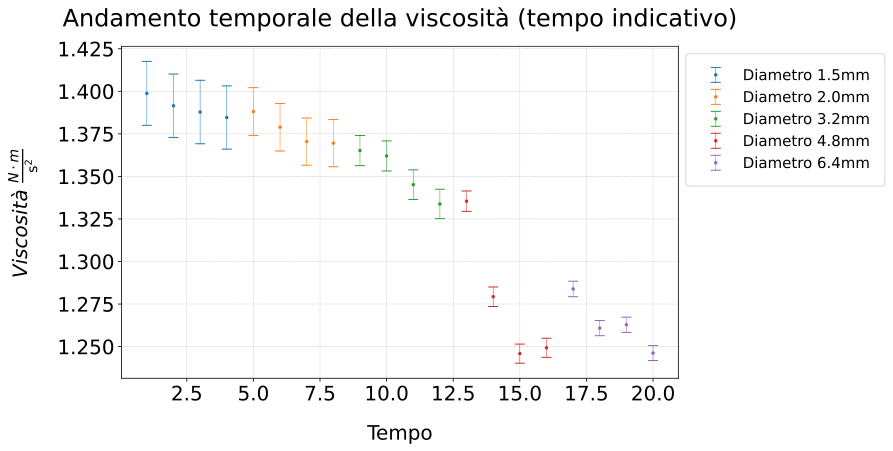

In [22]:
ascisse = [[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16], [17,18,19,20]] #tempi indicativi

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
color_cycle = itertools.cycle(colors)
diameter = ['1.5','2.0','3.2','4.8','6.4']
diameter_cycle = itertools.cycle(diameter)

plt.figure(dpi=1000,figsize=(10, 6))
for i in range (len(veta_tempi)):
    color = next(color_cycle)
    diameter = next(diameter_cycle)
    label = f"Diametro {diameter}mm"
    plt.errorbar(ascisse[i], veta_tempi[i], yerr=vseta_tempi[i], fmt='.', elinewidth=0.5, capsize=5, capthick=1, markersize=5, color=color, ecolor=color, label = label)

plt.xlabel("Tempo")
plt.ylabel(r"${Viscosità \ \frac{N \cdot m}{\mathrm{s^2}}}$")
plt.title("Andamento temporale della viscosità (tempo indicativo)")
plt.grid()
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(f"{nome}5.pdf", format="pdf", bbox_inches='tight')
plt.show()

### 3.5 Valutazione Effetto Memoria

E' stata fatta un'interpolazione (minimi quadrati 2, ordinate eta) di cui serve verificare la compatibilità della pendenza con la pendenza nulla. Si ricordi che il tempo nell'ascisse è indicativo.

In [23]:
output_name = f"{nome}_elaborato_memoria.txt"
with open (output_name, 'w') as file:
    file.write('\n')
for i in range (len(veta_tempi)):
    f.elaborato2(ascisse[i], veta_tempi[i],vseta_tempi[i], output_name, i)

del output_name

# 4. Confronto Glicerolo-Sapone

### 4.1 Dati

In [24]:
d_g = [0.0015, 0.002, 0.00318, 0.00476, 0.00635]
vv_g = [0.005848584630897728, 0.010575679262215221, 0.027260964308315698, 0.06382788558202258, 0.11512694303169776]
vsv_g = [1.5107723646593004e-05, 3.106982273421193e-05, 0.0001543042201740087, 0.0012116548845597988, 0.002848823025224685]
veta_g = [1.3854106216688666, 1.3620670712239062, 1.3358564733519138, 1.2783513108446085, 1.261296675770493]
vseta_g = [0.018933674032854793, 0.014347230349116273, 0.011484947896080115, 0.024930684589884042, 0.03152131567049107]

d_s = [0.0015, 0.002, 0.00318, 0.00476, 0.00635]
vv_s = [0.0011062374207969241, 0.002057759304913559, 0.0053914704394030545, 0.01404328788939443, 0.03942497045810502]
vsv_s =[1.1565134732745702e-05, 1.0765982305142885e-05, 2.3995212166598997e-05, 5.329079430070025e-05, 0.0012170853151817196]
veta_s = [7.577197081334085, 7.241688297544369, 6.987493583397883, 6.010623387790249, 3.8102237916845803]
vseta_s = [0.12839427058286382, 0.08174641048267421, 0.05386097662866154, 0.03405824925154938, 0.11823899926893798]

### 4.2 Grafico Confronto

Nome output "confronto.png" e animazione "confronto.gif". La superficie è indicativa e, anche se i dati sembrano (qualitativamente) seguirla, non va intesa come una verifica della Legge di Stokes. Teoricamente le superfici dovrebero essere due (perchè le densità variano tra glicerolo e sapone), ma, essendo esse estremamente vicine (almeno per quanto riguarda l'ingrandimento di questo grafico) si è deciso di mantenere una densità media tra glicerolo e sapone (sottratta alla densità delle sferette, come da Legge di Stokes).

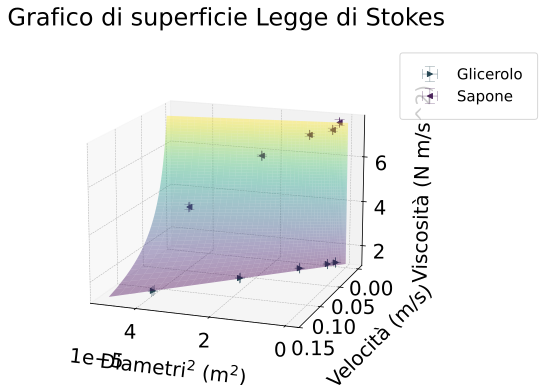

'def rotate(frame):\n    ax.view_init(elev=15, azim=frame)\n\nani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, 2), interval=10000)\nani.save(f"confronto.gif", writer=\'imagemagick\', fps=15)\nplt.show()'

In [25]:
d_g = np.array(d_g)
vv_g = np.array(vv_g)
vsv_g = np.array(vsv_g)
veta_g = np.array(veta_g)
vseta_g = np.array(vseta_g)

d_s = np.array(d_s)
vv_s = np.array(vv_s)
vsv_s = np.array(vsv_s)
veta_s = np.array(veta_s)
vseta_s = np.array(vseta_s)

rho_g = 1260
srho_g = 10
rho_s = 1032
srho_s = 1

#superficie
d_values = np.linspace(0.000001, 0.007, 50)
veta_values = np.linspace(1.261296675770493, 7.577197081334085, 50)
D, VETA = np.meshgrid(d_values, veta_values)
VV_s = (rho - rho_s) * g * D ** 2 / (18 * VETA)
VV_g = (rho - rho_g) * g * D ** 2 / (18 * VETA)

fig = plt.figure(dpi=200, figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.errorbar(d_g**2, vv_g, veta_g, xerr = 2*d_g*sd, yerr = vsv_g, zerr = vseta_g, color = "#264653", fmt =">", elinewidth=0.3, capsize=5, capthick=0.3, markersize=5, label = "Glicerolo")
ax.errorbar(d_s**2, vv_s, veta_s, xerr = 2*d_s*sd, yerr = vsv_s, zerr = vseta_s, color = "#4A235A", fmt ="<", elinewidth=0.3, capsize=5, capthick=0.3, markersize=5, label = "Sapone")
ax.plot_surface(D**2, VV_g, VETA, cmap = "viridis", alpha=0.4, edgecolor='none')
#ax.plot_surface(D**2, VV_s, VETA, facecolor = "red", alpha=0.1, edgecolor='none')

ax.set_xlabel(r"$\mathrm{Diametri^2\ (m^2)}$")
ax.set_ylabel("Velocità (m/s)")
ax.set_zlabel("Viscosità (N m/s^2)")
ax.set_title("Grafico di superficie Legge di Stokes")
ax.view_init(elev=15, azim=110)
#ax.view_init(elev=0, azim=270) #Viscosità in funzione del diametro
#ax.view_init(elev=90, azim=270) #Velocità in funzione della diametro
plt.legend(bbox_to_anchor=(1,1))
plt.savefig(f"confronto.pdf", format="pdf")
plt.show()

"""def rotate(frame):
    ax.view_init(elev=15, azim=frame)

ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, 2), interval=10000)
ani.save(f"confronto.gif", writer='imagemagick', fps=15)
plt.show()"""

Come si può vedere i dati del sapone sono vistosamente superiori, ma soprattutto sembrano crescere. La viscosità è costante per un materiale, il chè vuol dire che le rette dei dati di sapone e glicerolo dovrebbero essere orizzontali. Nel grafico che mette a confronto viscosità in funzione del diametro quadrato si può quantificare quanto questa affermazione è corrispondente ai dati attraverso un confronto della pendenza della retta interpolante con una costante.
